In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

import collections
import functools
import abc
import random

import numpy as np
import jax
import jax.numpy as jnp
import jax.experimental.optimizers
import scipy.stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq
import dict_minimize
from pytictoc import TicToc

import bvbq

# import bvbq.gp
# import bvbq.bvi
# import bvbq.distributions

In [4]:
random.random()

0.8553651661648254

In [5]:
key1 = jax.random.PRNGKey(250)
key2,_ = jax.random.split(key1)
# mixmeans_test = 4*jax.random.normal(key1,shape=(12,1))
mixmeans_test = jnp.ones((12,1))
mixmeans_test = jnp.array([[  1.8033],
                           [ -1.4296],
                           [ -1.9691],
                           [  1.2147],
                           [ -6.9166],
                           [-11.5672],
                           [ -1.5860],
                           [ -4.3302],
                           [  8.7410],
                           [ -1.3793],
                           [ -4.8774],
                           [  2.3949]])
mixvars_test = jnp.ones((12,1))
mixweights_test = jnp.ones(12)/12
# mixmeans_test = jnp.array([[3.0],[-3.0]])
# mixvars_test = jnp.ones((2,1))
# mixweights_test = jnp.ones(2)/2
# bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples,mixmeans,mixvars,mixweights)

In [6]:
def logprob_mixgaussians(x):
    return bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                        x,mixmeans_test,mixvars_test,mixweights_test).reshape(-1,1)
def logprob_t(x,nu):
    normalizer = jax.scipy.special.gammaln((nu+1)/2) \
                 -jax.scipy.special.gammaln(nu/2) \
                 -0.5*jnp.log(jnp.pi*nu)
    main_term = -(nu+1)/2*jnp.log(1+x**2/nu)
    return main_term + normalizer

xdata = jnp.linspace(-20,20,51).reshape(-1,1)
# ydata = logprob_t(xdata,2.5)
ydata = logprob_mixgaussians(xdata)
logprobgp = bvbq.gp.SimpleGP(1,kind='sqe',noise=0,zeromax=True)
logprobgp.mean = -10.0
logprobgp.fix_mean()
logprobgp.fix_noise()
logprobgp.set_data(xdata,ydata,empirical_params=False)
logprobgp.optimize_params()

OrderedDict([('raw_theta', DeviceArray(0.5413248, dtype=float32)),
             ('raw_lengthscale', DeviceArray(0.5413248, dtype=float32)),
             ('raw_noise', DeviceArray(-inf, dtype=float32))])

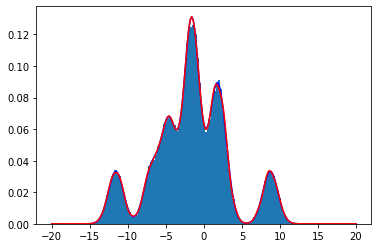

In [7]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot)
# yplot1 = logprob_t(xplot,2.5)
yplot2 = logprobgp.predict(xplot,return_cov=False)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
samples1 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(100000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test,
                                                             key1,key2)
plt.hist(samples1.flatten(),density=True,bins=100);

In [8]:
def mcbq_dmvn_elbo(logprobgp,mean,var,nsamples):
    term1 = 0.5*jnp.sum(jnp.log(2*jnp.pi*jnp.e*var))
    term2 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False)
    return term1 + term2
#     term1 = distrib.monte_carlo_entropy(nsamples)
#     term2 = bq.monte_carlo_bayesian_quadrature(logprobgp,distrib,nsamples)
#     return term1 + term2

def objective_function_elbo(params):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    res = -mcbq_dmvn_elbo(logprobgp,mean,var,1000)
    return res

In [9]:
params = {'mean':jnp.zeros(1)-1.0,'rawvar':jnp.zeros(1)}
jax.value_and_grad(objective_function_elbo)(params)
maxiter = 100
alpha = 1e-1
optwrapper = bvbq.optwrapper.JaxOptWrapper("adam",alpha)
func_and_grad_elbo = jax.value_and_grad(objective_function_elbo)
optwrapper.init(params,func_and_grad_elbo)
for k in range(maxiter):
    value,grads = optwrapper.step()
    params = optwrapper.params
#     print(value,params['mean'],jax.nn.softplus(params['rawvar']))
mean,rawvar = params['mean'],params['rawvar']
var = jax.nn.softplus(rawvar)
distrib = bvbq.distributions.DiagonalNormalDistribution(mean,var)

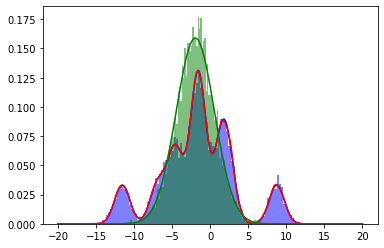

In [10]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
# yplot1 = logprob_t(xplot,2.5)
yplot1 = logprob_mixgaussians(xplot)
yplot2 = logprobgp.predict(xplot,return_cov=False)
yplot3 = distrib.logprob(xplot).reshape(-1,1)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
plt.plot(xplot,jnp.exp(yplot3),'g')
samples1 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(10000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test,
                                                             key1,key2)
samples3 = distrib.sample(10000)
plt.hist(samples1.flatten(),density=True,bins=100,alpha=0.5,color='blue');
plt.hist(samples3.flatten(),density=True,bins=100,alpha=0.5,color='green');

In [11]:
def mcbq_dmvn_relbo(logprobgp,mean,var,mixmeans,mixvars,mixweights,
                    zsamples,logdelta,reg):
    samples = jnp.sqrt(var)*zsamples + mean
    term1 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False) #Variance
#     term2 = bvbq.utils.lb_mvn_mixmvn_cross_entropy(mean,var,mixmeans,mixvars,mixweights,logdelta)
    term2_ = bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                    samples,mixmeans,mixvars,mixweights)
    term2_ = bvbq.utils.logbound(term2_,logdelta)
    term2 = -term2_.mean()
    term3 = 0.5*jnp.sum(jnp.log(2*jnp.pi*jnp.e*var)) #Entropy
    return term1 + term2 + reg*term3

def mcbq_mixdmvn_gradboost_delbodw(weight,logprobgp,mean,var,
                                   mixmeans,mixvars,mixweights,
                                   key,nsamples=100):
    mixmeans_up = jnp.vstack([mixmeans,mean])
    mixvars_up = jnp.vstack([mixvars,var])
    mixweights_up = jnp.append((1-weight)*mixweights,weight)

    subkeya,key = jax.random.split(key)
    subkeyb,key = jax.random.split(key)
    subkeyc,key = jax.random.split(key)

    nmixtures,ndim = mixmeans.shape
    catinds = jax.random.choice(subkeya,nmixtures,shape=(nsamples,),p=mixweights)
    zprevious = jax.random.normal(subkeyb,shape=(nsamples,ndim))
    zproposal = jax.random.normal(subkeyc,shape=(nsamples,ndim))
    samplesprevious = bvbq.utils.mixdmvn_samples_from_zsamples_catinds(mixmeans,mixvars,zprevious,catinds)
    samplesproposal = bvbq.utils.dmvn_samples_from_zsamples(mean,var,zproposal)

    term1 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False) 
    term2 = -bvbq.bq.separable_mixdmvn_bq(logprobgp,mixmeans,
                                          mixvars,mixweights,
                                          return_var=False)
    term3 = -bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                samplesproposal,mixmeans_up,mixvars_up,mixweights_up).mean()
    term4 = bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                samplesprevious,mixmeans_up,mixvars_up,mixweights_up).mean()
    return term1 + term2 + term3 + term4

# @jax.jit
def mcbq_mixdmvn_gradboost_delbodw_term34(weight,term1,term2,mean,var,
                                          mixmeans,mixvars,mixweights,
                                          catinds,zprevious,zproposal):
    mixmeans_up = jnp.vstack([mixmeans,mean])
    mixvars_up = jnp.vstack([mixvars,var])
    mixweights_up = jnp.append((1-weight)*mixweights,weight)

    samplesprevious = bvbq.utils.mixdmvn_samples_from_zsamples_catinds(mixmeans,mixvars,zprevious,catinds)
    samplesproposal = bvbq.utils.dmvn_samples_from_zsamples(mean,var,zproposal)

    term3 = -bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                samplesproposal,mixmeans_up,mixvars_up,mixweights_up).mean()
    term4 = bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                samplesprevious,mixmeans_up,mixvars_up,mixweights_up).mean()
    return term1 + term2 + term3 + term4

def make_gradboost_samples(key,nsamples,mixweights,nmixtures,ndim):
    subkeya,key = jax.random.split(key)
    subkeyb,key = jax.random.split(key)
    subkeyc,key = jax.random.split(key)

    nmixtures,ndim = mixmeans.shape
    catinds = jax.random.choice(subkeya,nmixtures,shape=(nsamples,),p=mixweights)
    zprevious = jax.random.normal(subkeyb,shape=(nsamples,ndim))
    zproposal = jax.random.normal(subkeyc,shape=(nsamples,ndim))
    return catinds,zprevious,zproposal

In [12]:
def objective_function_relbo(params,mixmeans,mixvars,mixweights,
                             logdelta,reg,nsamples,key):
    mean,rawvar = params['mean'],params['rawvar']
    zsamples = jax.random.normal(key,shape=(nsamples,mean.shape[0]))
    var = jax.nn.softplus(rawvar)
    res = -bvbq.bvbq_functions.mcbq_dmvn_relbo(logprobgp,mean,var,mixmeans,mixvars,mixweights,zsamples,logdelta,reg)
    return res

func_and_grad_relbo = jax.value_and_grad(objective_function_relbo,argnums=0)

In [ ]:
# mean,var = distrib.params
# mixmeans = mean.reshape(1,-1)
# mixvars = var.reshape(1,-1)
dim = 1
mean = jnp.zeros((dim,))
var = (20.0/3)**2*jnp.ones((dim,))
mean,var = distrib.params
mixmeans = jnp.expand_dims(mean,-1)
mixvars = jnp.expand_dims(var,-1)*12
mixweights = jnp.ones(1)

alpha_relbo = 0.1
maxiter_relbo = 100
alpha_boost = 0.1
maxiter_boost = 100
maxiter = 400
optwrapper = bvbq.optwrapper.JaxOptWrapper("adam",alpha_relbo)

key = jax.random.PRNGKey(365)

tictoc = TicToc()
for k in range(maxiter):
    tictoc.tic()
    subkeya,key = jax.random.split(key)
    subkeyb,key = jax.random.split(key)
    subkeyc,key = jax.random.split(key)
    mean_init = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(
                    1,mixmeans,mixvars,mixweights,subkeya,subkeyb)[0]
    var_init = jnp.array(scipy.stats.halfnorm.rvs(size=(1,)),dtype=jnp.float32)
    rawvar_init = jnp.log(jnp.exp(var_init)-1)
    params = {'mean':mean_init,
              'rawvar':rawvar_init}
    params = collections.OrderedDict(params)
    
    optwrapper.init(params,func_and_grad_relbo)
    reg = random.random()
    for i in range(maxiter_relbo):
        subkeyd,key = jax.random.split(key)
        value,grads = optwrapper.step(mixmeans,mixvars,mixweights,-20,reg,
                                      1000,subkeyd)
    params = optwrapper.params
#     res = dict_minimize.jax_api.minimize(func_and_grad_relbo, params,
#                                          args=(mixmeans,mixvars,mixweights,-20,random.random(),
#                                                1000,subkeyd),
#                                          method='L-BFGS-B',
#                                          tol=1e-6)
    tictoc.toc()
    mean,var = params['mean'],jax.nn.softplus(params['rawvar'])
    weight = 1e-4
    term1 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False) 
    term2 = -bvbq.bq.separable_mixdmvn_bq(logprobgp,mixmeans,
                                          mixvars,mixweights,
                                          return_var=False)
    nmixtures,ndim = mixmeans.shape
    tictoc.tic()
    nsamples = 100
    for i in range(maxiter_boost):
        subkeye,key = jax.random.split(key)
        catinds,zprevious,zproposal = make_gradboost_samples(subkeye,nsamples,mixweights,nmixtures,ndim)
        gradweight = -mcbq_mixdmvn_gradboost_delbodw_term34(weight,term1,term2,mean,var,
                                                            mixmeans,mixvars,mixweights,
                                                            catinds,zprevious,zproposal)
        dweight = alpha_boost/(k+1)*gradweight
        weight -= dweight
        weight = jnp.clip(weight,1e-4,1-1e-4)
        if abs(gradweight) < 1e-4:
            break
    tictoc.toc()
#     mixdistrib.add_component(mean,var,weight)
    mixweights = jnp.append((1-weight)*mixweights,weight)
    mixmeans = jnp.vstack([mixmeans,mean])
    mixvars = jnp.vstack([mixvars,var])
    print(k,mean,var,weight)
    print('--')
    

Elapsed time is 3.860047 seconds.
Elapsed time is 1.957695 seconds.
0 [-11.650252] [0.523025] 0.36141512
--
Elapsed time is 3.163304 seconds.
Elapsed time is 1.098759 seconds.
1 [-2.1017208] [6.844118] 0.96465546
--
Elapsed time is 3.318795 seconds.
Elapsed time is 1.130336 seconds.
2 [2.6523876] [0.27660152] 0.08283778
--
Elapsed time is 3.162522 seconds.
Elapsed time is 1.103293 seconds.
3 [1.100503] [8.041198] 0.06734057
--
Elapsed time is 3.239716 seconds.
Elapsed time is 0.593997 seconds.
4 [-0.5829338] [7.3400474] 0.0027548722
--
Elapsed time is 3.241774 seconds.
Elapsed time is 1.105618 seconds.
5 [-0.87005925] [9.272048] 0.026347354
--
Elapsed time is 3.272381 seconds.
Elapsed time is 1.118016 seconds.
6 [0.08073165] [4.9894958] 0.0013914964
--
Elapsed time is 3.369550 seconds.
Elapsed time is 1.102539 seconds.
7 [-12.039369] [1.1379865] 0.072043866
--
Elapsed time is 3.290134 seconds.
Elapsed time is 1.113928 seconds.
8 [-7.5872474] [0.08665314] 0.019957647
--
Elapsed time is 

Elapsed time is 3.479840 seconds.
Elapsed time is 1.209787 seconds.
74 [-5.525405] [3.8557506] 0.00087199366
--
Elapsed time is 3.476018 seconds.
Elapsed time is 1.235210 seconds.
75 [-4.3203936] [7.6822834] 0.0006691113
--
Elapsed time is 3.478461 seconds.
Elapsed time is 1.256318 seconds.
76 [-2.4216464] [7.9700623] 0.0013088447
--
Elapsed time is 3.597966 seconds.
Elapsed time is 1.230243 seconds.
77 [-0.539358] [6.579922] 0.0016770092
--
Elapsed time is 3.585668 seconds.
Elapsed time is 1.223896 seconds.
78 [8.755832] [2.8074317] 0.009954309
--
Elapsed time is 3.473350 seconds.
Elapsed time is 1.234938 seconds.
79 [-5.510621] [2.030226] 0.0027954984
--
Elapsed time is 3.503076 seconds.
Elapsed time is 1.241602 seconds.
80 [-1.6064813] [5.511863] 0.0015736959
--
Elapsed time is 3.466711 seconds.
Elapsed time is 0.991545 seconds.
81 [-1.5357416] [0.45958632] 0.006396459
--
Elapsed time is 3.489054 seconds.
Elapsed time is 1.276219 seconds.
82 [-0.627219] [6.6724863] 1e-04
--
Elapsed 

Elapsed time is 3.661051 seconds.
Elapsed time is 1.269828 seconds.
148 [7.936055] [6.0235705] 1e-04
--
Elapsed time is 3.692795 seconds.
Elapsed time is 1.268111 seconds.
149 [8.779462] [2.5491693] 1e-04
--
Elapsed time is 3.666935 seconds.
Elapsed time is 1.254468 seconds.
150 [-0.7649119] [8.916329] 0.0013818756
--
Elapsed time is 3.652905 seconds.
Elapsed time is 1.250162 seconds.
151 [-0.2982329] [5.8926873] 0.00050854514
--
Elapsed time is 3.652540 seconds.
Elapsed time is 1.286249 seconds.
152 [-0.3584254] [5.675774] 0.0005232472
--
Elapsed time is 3.619694 seconds.
Elapsed time is 1.257091 seconds.
153 [8.485758] [3.4270978] 1e-04
--
Elapsed time is 3.655425 seconds.
Elapsed time is 1.280159 seconds.
154 [-0.68377745] [7.3254194] 0.0009232605
--
Elapsed time is 3.679481 seconds.
Elapsed time is 1.290271 seconds.
155 [-0.3981292] [5.4517374] 0.00023208254
--
Elapsed time is 3.718992 seconds.
Elapsed time is 1.294604 seconds.
156 [-3.9896529] [7.0163827] 0.0002799861
--
Elapsed t

Elapsed time is 3.763159 seconds.
Elapsed time is 1.217846 seconds.
222 [-0.6252391] [7.560704] 0.001087086
--
Elapsed time is 3.603638 seconds.
Elapsed time is 1.376724 seconds.
223 [-1.1073564] [0.00285744] 0.0034245339
--
Elapsed time is 3.691418 seconds.
Elapsed time is 1.377173 seconds.
224 [-3.5823104] [5.90138] 0.0003092479
--
Elapsed time is 3.713359 seconds.
Elapsed time is 1.396626 seconds.
225 [-2.613052] [9.279837] 0.0007881709
--
Elapsed time is 3.712871 seconds.
Elapsed time is 1.392515 seconds.
226 [-11.558273] [0.9700753] 0.0026397884
--
Elapsed time is 3.747564 seconds.
Elapsed time is 1.400466 seconds.
227 [-0.47916174] [7.4015756] 0.00039512603
--
Elapsed time is 3.740679 seconds.
Elapsed time is 1.393516 seconds.
228 [-4.45894] [8.124966] 0.00069925055
--
Elapsed time is 3.722682 seconds.
Elapsed time is 1.388917 seconds.
229 [-4.5034075] [7.847631] 0.00059917377
--
Elapsed time is 3.731746 seconds.
Elapsed time is 1.392317 seconds.
230 [-4.336751] [7.458982] 0.0005

In [ ]:
logprobgp = bvbq.gp.SimpleGP(1,kind='smatern32',noise=0,zeromax=True)
logprobgp.mean = -20.0
logprobgp.noise = data['noise']
logprobgp.lengthscale = data['lengthscale']
logprobgp.theta = data['outputscale']
logprobgp.set_data(data['X'],data['y'].flatten(),empirical_params=False)
# logprobgp.optimize_params()

In [ ]:
res

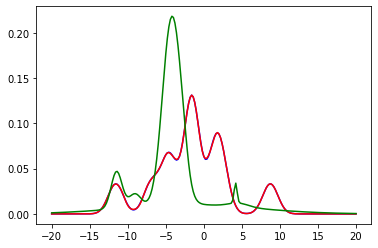

In [107]:
boostdistrib = bvbq.distributions.MixtureDiagonalNormalDistribution(mixmeans,mixvars,mixweights)
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot)
yplot2 = logprobgp.predict(xplot,return_cov=False)
yplot3 = boostdistrib.logprob(xplot).reshape(-1,1)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
plt.plot(xplot,jnp.exp(yplot3),'g')

In [298]:
mixmeans

DeviceArray([[ -1.960696  ],
             [-21.302664  ],
             [ -7.475327  ],
             [ -7.8455486 ],
             [  7.0041175 ],
             [ -8.77343   ],
             [ -3.9261105 ],
             [ -4.515048  ],
             [ -4.2821555 ],
             [ -3.8855982 ],
             [ -2.9858692 ],
             [ -5.014992  ],
             [ -8.516691  ],
             [ -5.443662  ],
             [ -5.4247546 ],
             [ -6.974314  ],
             [ -1.8054025 ],
             [ -5.5780435 ],
             [ -5.086027  ],
             [ -6.221151  ],
             [ -0.5384201 ],
             [ -1.5548795 ],
             [ -2.3095999 ],
             [  1.9781837 ],
             [ -7.5360165 ],
             [ -3.2856658 ],
             [ -5.0841985 ],
             [ -6.8157225 ],
             [ -2.3189285 ],
             [  3.0821881 ],
             [  0.78526586],
             [ -2.5410705 ],
             [ -3.5567799 ],
             [  0.8251402 ],
             [

In [22]:
func_and_grad_relbo(params,mixmeans,mixvars,mixweights,-20,-1.0)

NameError: name 'mixmeans' is not defined

In [317]:
subkey,key = jax.random.split(key)
func_and_grad_gradboost(weight,mean,var,mixmeans,mixvars,mixweights,subkey)

(DeviceArray(0.7377595, dtype=float32), DeviceArray(-1.0448856, dtype=float32))

In [318]:
mcbq_mixdmvn_gradboost_delbodw(weight,logprobgp,mean,var,mixmeans,mixvars,mixweights,subkey,nsamples=100)

DeviceArray(0.92413974, dtype=float32)